In [537]:
#IN google colab install abtem and pycu for gpu acceleration:
#!pip install abtem
#!pip install pycu

%matplotlib inline

from abtem import __version__
print('current version:', __version__)

import matplotlib.pyplot as plt
from ase.io import read
from ase.build import mx2

from abtem import *
from abtem.structures import orthogonalize_cell

from ase.spacegroup import crystal

from ase.visualize import view

from abtem.transfer import scherzer_defocus
import numpy as np

import matplotlib.pyplot as plt

from abtem.utils import fft_shift
from abtem.aperture import DeviatedAperture
import scipy.constants as c

current version: 1.0.0beta26


In [538]:
def imshow(X, *args, **kwargs):
    return plt.imshow(X=np.flip(X,axis=0),*args, **kwargs)
    #return plt.imshow(X=np.swapaxes(X,0,1),*args, **kwargs)
    #return plt.imshow(X=np.swapaxes(np.flip(X,axis=0),0,1),*args, **kwargs)

# SrTiO$_3$

We build an atomic structure of MoS2 with ASE. Since abTEM requires an orthogonal we make the cell orthogonal. We also need to repeat the structure, so the probe fits inside the cell.

<AxesSubplot:title={'center':'Side view'}, xlabel='x [Å]', ylabel='z [Å]'>

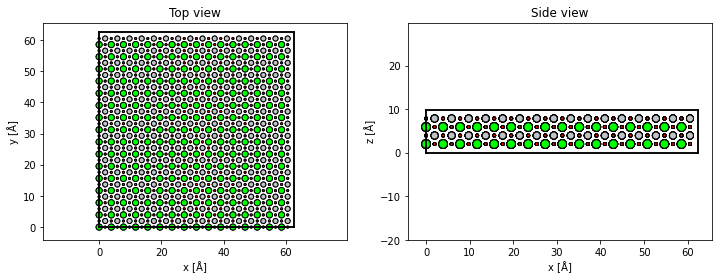

In [539]:
atom_pos = [(0.0, 0.0, 0.0), (0.5, 0.5, 0.5), (0.5, 0.5, 0.0)]
srtio3 = crystal(['Sr','Ti','O'], atom_pos, spacegroup=221, cellpar=3.905, size=(1, 1, 2))
atoms = srtio3

repetitions = (16, 16, 1)

atoms = orthogonalize_cell(atoms)

atoms *= repetitions

atoms.center(vacuum=2, axis=2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

show_atoms(atoms, ax=ax1, title='Top view')
show_atoms(atoms, ax=ax2, plane='xz', title='Side view')

In [540]:
#view(atoms)

In [541]:
print(f"Simulation cell: {atoms.cell}")

Simulation cell: Cell([62.48, 62.48, 9.8575])


We create and calculate the electrostatic potential.

In [542]:
gpts=512
potential = Potential(atoms, 
                      gpts=gpts,
                      projection='finite', 
                      slice_thickness=1, 
                      parametrization='kirkland')

potential = potential.build()

10

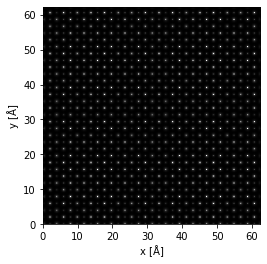

In [543]:
potential.project().show()
len(potential)

In [544]:
print(f"Real space sampling: {potential.sampling}")

Real space sampling: (0.12203125, 0.12203125)


In [545]:
#Functions for calculation of abberation coefficients for deviated probe and transformed probe using (C1,A1,...) noteation

In [546]:
from abtem.transfer import cartesian2polar
def m2A(m):
    return(m/1e-10)

def Haider2Krivanek(C1,A1,C3,B2,A2=0+0*1j):
    cartesian = dict()
    
        
    #C1 - C10
    #A1 - C12
    #B2 - 1/3*np.conjugated(C21) !!
    #A2 - # it is zero
    #C3 - C30
    
    cartesian['C10']  = m2A(C1.real)
    cartesian['C12a'] = m2A(A1.real)
    cartesian['C12b'] = m2A(A1.imag)
    cartesian['C21a'] = m2A(3*B2.real) # there should be conjugation
    cartesian['C21b'] = m2A(3*B2.imag) # there should be conjugation
    cartesian['C30']  = m2A(C3)
    
    cartesian['C23a']  = m2A(A2.real)
    cartesian['C23b']  = m2A(A2.imag)
    return(cartesian)

def get_coeffs(C1,A1,C3,B2=0*1j,A2=0+0*1j): #parameters in argumentC1,A1,.. are original values of aberations in [m]
    A0=0+0*1j
    cartesian = Haider2Krivanek(C1,A1,C3,B2,A2)
    return(m2A(A0).real,m2A(A0).imag,cartesian2polar(cartesian)) #returning in angstrems

def get_transformed_coeffs(C1,A1,C3,delta): #parameters in argument C1, A1,.. are original values of aberations in [m]
    A0_new = C1*delta+A1*delta.conjugate()+C3*delta**2*delta.conjugate()
    print("delta: ",delta)
    print("A1: " , A1)
    print("A0_new: ", A0_new)
    C1_new = C1+2*C3*delta*delta.conjugate() #C1_new,A1_new,.. are values of aberations after transformation of variables into the ones with shifted aperture
    A1_new = A1+C3*delta**2
    B2_new = C3*delta# according to theory there should be C3*delta.conjugate() but that does not work.. probably cuz phase deviation in notation (C1,A1,C3,B2...) differs in term with B2 so that C21a,C21b corresponds to 3*B2.conjugate() IMO, but.. modifying B2 in `Haider2Krivanek()`, will make wrong results in case of simulating profiles with DeviatedAperture
    #A2_new =  # it is zero
    C3_new = C3 

    cartesian = Haider2Krivanek(C1_new,A1_new,C3_new,B2_new)

    return(m2A(A0_new).real,m2A(A0_new).imag,cartesian2polar(cartesian)) #returning in angstrems

_, _, aberations_dict = get_transformed_coeffs(C1=0,A1=0,C3=1.9e-3,delta=0+0*1j)



energy=200e3
phi_star=energy*(1-c.elementary_charge*energy/2/c.m_e/c.c**2)

#temporal coherrence
Cc=1.61e-3/1e-10 # In Angstrem
focal_spread=Cc*(0.6/200e3)

#spatial coherrence
reduced_brightness=1e8
d=1*2*1e-10 # from graph below with C3=0 
I=0.2e-9
alphaa=np.sqrt(4*I/np.pi**2/d**2/reduced_brightness/phi_star)
beta=1/np.e*alphaa*1e3#1/e of angle distribution in [mrad]
angular_spread=beta

defocus_0=scherzer_defocus(Cs=aberations_dict["C30"],energy=energy)        

delta:  0j
A1:  0
A0_new:  0j


In [547]:
%matplotlib inline

In [548]:
semiangle_cutoff=9.5

In [549]:
probe = Probe(energy=energy, semiangle_cutoff=semiangle_cutoff, rolloff=0.1, defocus=defocus_0, Cs=aberations_dict["C30"], angular_spread=angular_spread,focal_spread=focal_spread)

To run this simulation using PRISM instead of the standard multislice algorithm, uncomment the cell below. Note that while PRISM may be up to a 1000 times faster than multislice for large structures, the performance is fairly similar for small simulations like this.

In [550]:
#probe = SMatrix(energy=energy, semiangle_cutoff=11.3, expansion_cutoff=20, rolloff=0.1, defocus=defocus_0, Cs=aberations_dict["C30"])
#probe = SMatrix(energy=energy, semiangle_cutoff=9.5, expansion_cutoff=20, rolloff=0.1, defocus=defocus_0, Cs=aberations_dict["C30"],angular_spread=angular_spread,focal_spread=focal_spread)
#_, _, aberations_dict = get_transformed_coeffs(C1=-defocus_0*1e-10,A1=0,C3=1.9e-3,delta=0e-3+0*1j) 
#probe.ctf.set_parameters(aberations_dict)

In [551]:
print("defocus_0: ",defocus_0)
print("angular_spread: ",angular_spread)
print("focal_spread: ",focal_spread)

defocus_0:  845.4355085066284
angular_spread:  4.129003900122874
focal_spread:  48.300000000000004


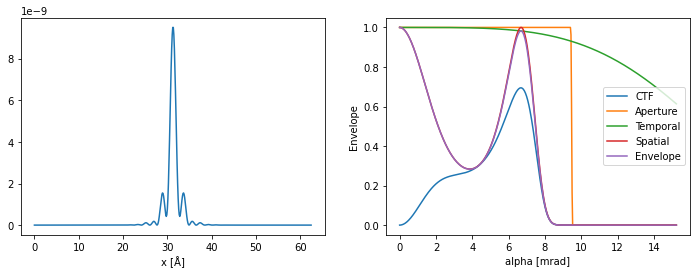

In [552]:
probe.grid.match(potential)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

probe.profile().show(ax=ax1);

probe.ctf.show(ax=ax2);

In [553]:
#Calculate radial intensity of probe and cumulative radial intensity for estimate of probe diameter (at 50% of current)

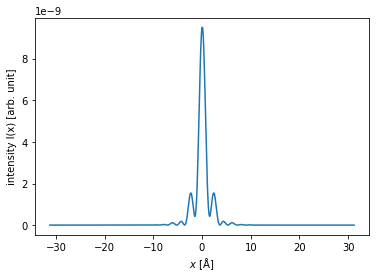

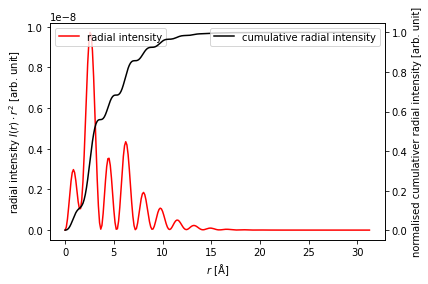

In [554]:
calibration=probe.profile().calibrations[0]
y = probe.profile().array #it is already intensity
x = np.linspace(calibration.offset, calibration.offset + len(y) * calibration.sampling, len(y))
x = x-calibration.sampling*len(y)/2

y_cropped = y[x >= 0]
x_cropped = x[x >= 0]

plt.plot(x,y)
plt.xlabel(r"$x$ [$\mathrm{\AA}$]")
plt.ylabel(r"intensity I(x) [arb. unit]")

radial_intensity = y_cropped * x_cropped**2 

fig, ax1 = plt.subplots() 

plt.plot(x_cropped,radial_intensity,"r",label="radial intensity")

plt.xlabel(r"$r$ [$\mathrm{\AA}$]")
plt.ylabel(r"radial intensity $I(r) \cdot r^2$ [arb. unit]")

ax1.legend(loc=2)

ax2=ax1.twinx()

cumulative_radial_intensity = np.cumsum(radial_intensity)/radial_intensity.sum() #relaying on the fact that sampling in position is equidistant
plt.plot(x_cropped,cumulative_radial_intensity,"k",label="cumulative radial intensity")
plt.ylabel(r"normalised cumulativer radial intensity [arb. unit]")
ax2.legend(loc=1)
plt.show()

In [555]:
#Show probe profile via abtem method

(<AxesSubplot:xlabel='x [Å]'>, <matplotlib.lines.Line2D at 0x7febe3c120a0>)

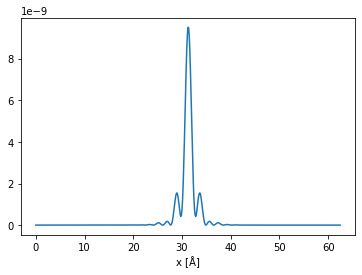

In [556]:
probe.profile().show()

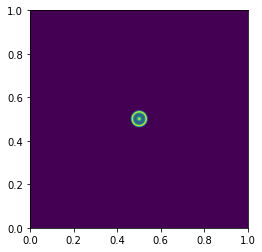

In [557]:
alpha, phi = probe.get_scattering_angles()
imshow(np.absolute(fft_shift(probe.ctf.evaluate_spatial_envelope(alpha,phi),np.array([gpts/2,gpts/2]))),extent=(0,1,0,1))

We create a `FlexibleAnnularDetector` detector which will allow us to choose the integration limits after the multislice simulation.

In [558]:
detector = FlexibleAnnularDetector()

In [326]:
#abberations
#A1s = [0];C1s = np.linspace(-(defocus_0-200)*1e-10,-(defocus_0+200)*1e-10,10);C3 = 1.9e-3 #-Defocus_0=C1a+iC1B=C1
A1s = np.linspace(-100*1e-9,400*1e-9,10);C1s = [-defocus_0*1e-10];C3 = 1.9e-3
delta_divisions = 7
#delta_semiangle = semiangle_cutoff
delta_semiangle =  5 # in mrad
deltas=np.zeros([delta_divisions,delta_divisions],np.complex256)
for i,delta_x in enumerate(np.linspace(-delta_semiangle*1e-3,delta_semiangle*1e-3,delta_divisions)):
    for j,delta_y in enumerate(np.linspace(delta_semiangle*1e-3,-delta_semiangle*1e-3,delta_divisions)):
        deltas[i,j]=delta_x+delta_y*1j
print(deltas)

deltas=np.array([np.linspace(delta_semiangle*1e-3,-delta_semiangle*1e-3,delta_divisions)])

index=0
for C1 in C1s:
    for A1 in A1s:
        for delta_row in deltas:
            for delta in delta_row:
                print(index);index += 1
                probe_transformed = Probe(energy=energy, semiangle_cutoff=semiangle_cutoff, rolloff=0.1, angular_spread=angular_spread,focal_spread=focal_spread)
                probe_transformed.grid.match(potential)

                C01a, C01b, aberations_dict_transformed = get_transformed_coeffs(C1=C1,A1=A1,C3=C3,delta=delta) #arguments in [m] and returns in angstrem
                probe_transformed.ctf.set_parameters(aberations_dict_transformed)
                print(probe_transformed.ctf.parameters)
                
                C01 = np.array([C01a,C01b])
                start = np.array([0,0])+C01 # it is supposed to be in angstrems
                end = np.array((potential.extent[0] / repetitions[0], potential.extent[1] / repetitions[1]))+C01
                gridscan = GridScan(start=start, end=end, sampling=probe_transformed.ctf.nyquist_sampling * .9)

                measurement_transformed = probe_transformed.scan(gridscan, detector, potential)
                measurement_transformed.integrate(50,80).interpolate(0.05).save_as_image("figs/{index:05d}_C1_{C1:.1f}-A1_{A1:.1f}-C3_{C3:.1f}-deltax_{deltax:.1f}-deltay_{deltay:.1f}.png".format(index=index,C1=C1/1e-10,A1=A1/1e-10,C3=C3/1e-10,deltax=delta.real*1e3,deltay=delta.imag*1e3))

[[-0.005     +0.005j      -0.005     +0.00333333j -0.005     +0.00166667j
  -0.005     +0.j         -0.005     -0.00166667j -0.005     -0.00333333j
  -0.005     -0.005j     ]
 [-0.00333333+0.005j      -0.00333333+0.00333333j -0.00333333+0.00166667j
  -0.00333333+0.j         -0.00333333-0.00166667j -0.00333333-0.00333333j
  -0.00333333-0.005j     ]
 [-0.00166667+0.005j      -0.00166667+0.00333333j -0.00166667+0.00166667j
  -0.00166667+0.j         -0.00166667-0.00166667j -0.00166667-0.00333333j
  -0.00166667-0.005j     ]
 [ 0.        +0.005j       0.        +0.00333333j  0.        +0.00166667j
   0.        +0.j          0.        -0.00166667j  0.        -0.00333333j
   0.        -0.005j     ]
 [ 0.00166667+0.005j       0.00166667+0.00333333j  0.00166667+0.00166667j
   0.00166667+0.j          0.00166667-0.00166667j  0.00166667-0.00333333j
   0.00166667-0.005j     ]
 [ 0.00333333+0.005j       0.00333333+0.00333333j  0.00333333+0.00166667j
   0.00333333+0.j          0.00333333-0.00166667j  

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

1
delta:  0.003333333333333333
A1:  -1.0000000000000001e-07
A0_new:  -5.447747991318391e-10
{'C10': -423.21328628440625, 'C12': -788.8888888888889, 'phi12': -1.5707963267948966, 'C21': 189999.99999999997, 'phi21': 1.5707963267948966, 'C23': 0.0, 'phi23': -0.0, 'C30': 19000000.0, 'C32': -0.0, 'phi32': -0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0.0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [473]:
delta_x

0.005

In [474]:
#Show probe for transformed probe

delta:  (0.005+0j)
A1:  0
A0_new:  (1.2500000000000002e-09+0j)
{'C10': 5000.000000000001, 'C12': -2500.0000000000005, 'phi12': -0.0, 'C21': 1500000.0, 'phi21': 1.5707963267948966, 'C23': 0.0, 'phi23': -0.0, 'C30': 100000000.0, 'C32': -0.0, 'phi32': -0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0.0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}
[12.5  0. ]


(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7febe226c9d0>)

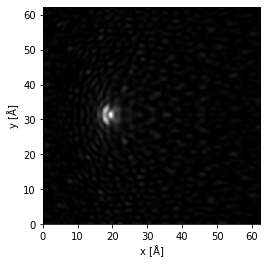

In [574]:
C3 = 1.0e-2#1.9e-3# in meters
defocus_0 = 0#-1000#845#1000# in angstrem
A1 = 0#500e-10#500e-10#100e-10#1000e-10#*(1+1j) in meters
probe_transformed = Probe(energy=energy, semiangle_cutoff=semiangle_cutoff, rolloff=0.1)#, angular_spread=angular_spread,focal_spread=focal_spread)
probe_transformed.grid.match(potential)

delta=5e-3+0e-3j
C01a, C01b, aberations_dict_transformed = get_transformed_coeffs(C1=-defocus_0*1e-10,A1=A1,C3=C3,delta=delta) #arguments in [m] and returns in angstrem
probe_transformed.ctf.set_parameters(aberations_dict_transformed)
print(probe_transformed.ctf.parameters)

C01 = np.array([C01a,C01b]) # I suppose that the coefficients should be interchanged 
print(C01)
start = np.array([0,0]) + C01 # it is supposed to be in angstrems
end = np.array((potential.extent[0] / repetitions[0], potential.extent[1] / repetitions[1])) + C01
gridscan = GridScan(start=start, end=end, sampling=probe_transformed.ctf.nyquist_sampling * .9)

#%matplotlib qt
#measurement = probe_transformed.scan(gridscan, detector, potential)
#measurement.integrate(50,80).interpolate(0.05).show()
probe_transformed.show()
#print(np.shape(measurement.array))

In [575]:
#Show probe for deviated probe

{'C10': 0.0, 'C12': -0.0, 'phi12': -0.0, 'C21': 0.0, 'phi21': 0.0, 'C23': 0.0, 'phi23': -0.0, 'C30': 100000000.0, 'C32': -0.0, 'phi32': -0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0.0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7febe21a1400>)

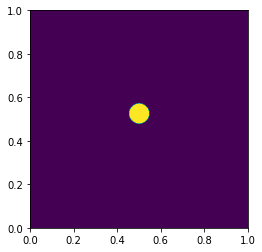

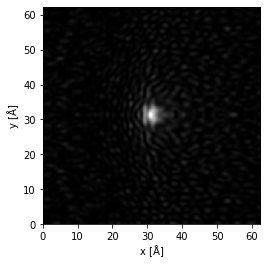

In [576]:
aperture = DeviatedAperture(aperture_angle=semiangle_cutoff,x_0=delta.imag*1e3,y_0=delta.real*1e3)

probe_deviated = Probe(aperture=aperture, energy=energy, semiangle_cutoff=2, rolloff=0.1)#, angular_spread=angular_spread,focal_spread=focal_spread)
probe_deviated.grid.match(potential)
imshow(np.absolute(fft_shift(probe_deviated.ctf.evaluate_aperture(alpha,phi),np.array([gpts/2,gpts/2]))),extent=(0,1,0,1))

_, _, aberations_dict_deviated = get_coeffs(C1=-defocus_0*1e-10,A1=A1,C3=C3,B2=0*1e-6,A2=(0+0j)*30e-6) #arguments in [m] and returns in angstrem
probe_deviated.ctf.set_parameters(aberations_dict_deviated)
#probe_deviated.ctf.set_parameters({'phi12': -3.1415/4})
print(probe_deviated.ctf.parameters)

start = np.array([0,0]) # it is supposed to be in angstrems
end = np.array((potential.extent[0] / repetitions[0], potential.extent[1] / repetitions[1]))
gridscan = GridScan(start=start, end=end, sampling=probe_deviated.ctf.nyquist_sampling * .9)

#measurement_deviated = probe_deviated.scan(gridscan, detector, potential)
#measurement_deviated.integrate(50,80).interpolate(0.05).show()
probe_deviated.show()

#print(np.shape(measurement_deviated.array))

In [516]:
#Showing probes via abtem methods

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7febe80cc580>)

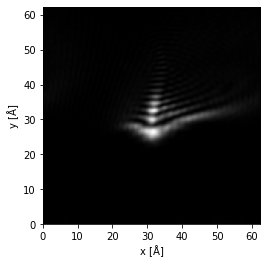

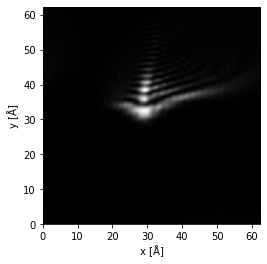

In [517]:
probe_deviated.show(log_scale=False)
probe_transformed.show(log_scale=False)

In [404]:
#Shifting transformed probe to see that it is simmilar to deviated one

In [450]:
%matplotlib qt
image_deviated=np.log(np.absolute(fft_shift(probe_deviated.build().array,np.array([0,0]))))[0]
image_transformed=np.log(np.absolute(fft_shift(probe_transformed.build().array,C01/probe_transformed.grid.sampling)))[0]
plt.figure()

extent=np.array(probe_deviated.grid.gpts)*probe_deviated.grid.sampling
imshow(np.swapaxes(image_deviated,0,1),extent=(0,extent[0],0,extent[1]))
plt.figure()
imshow(np.swapaxes(image_transformed,0,1),extent=(0,extent[0],0,extent[1]))
plt.show()

In [451]:
#Showing aperture

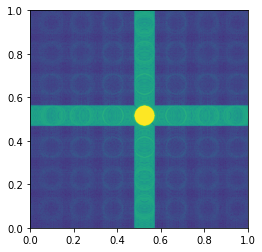

In [452]:
%matplotlib inline
values=probe_deviated.ctf.evaluate_aperture(alpha,phi)
image=np.log(np.absolute(fft_shift(values,np.array([gpts/2,gpts/2]))))
imshow(image,extent=(0,1,0,1))

In [408]:
#Show azimuthal angle phi

Text(0, 0.5, 'alpha_y')

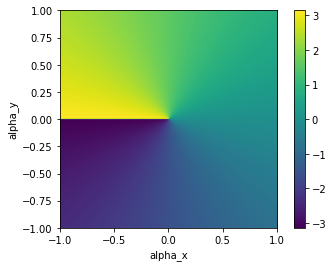

In [409]:
imshow(np.real(fft_shift(phi,np.array([gpts/2,-gpts/2]))),extent=(-1,1,-1,1)); plt.colorbar()
plt.xlabel("alpha_x")
plt.ylabel("alpha_y")

#imshow(np.absolute(fft_shift(probe_deviated.ctf.evaluate_aperture(alpha,phi),np.array([gpts/2,-gpts/2]))),extent=(0,1,0,1))
#imshow(np.absolute(probe_deviated.ctf.evaluate_aperture(alpha,phi)),extent=(0,1,0,1))

In [410]:
#Croscorrelation of obtained probes via deviation and transformation and their relative simillarity

3.3384026e-06
3.4040654e-06
1.0196689


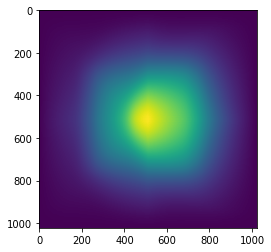

In [411]:
from scipy  import signal
p_deviated = np.abs(probe_deviated.build().array[0])
p_transformed = np.abs(probe_transformed.build().array[0])

p_deviated_sq = signal.fftconvolve(p_deviated,p_deviated[::-1]).max()

print(p_deviated_sq)

conv = signal.fftconvolve(p_deviated,p_transformed[::-1])
imshow(conv)

print(conv.max())

print(conv.max()/p_deviated_sq)

In [519]:
measurement = probe_deviated.build().intensity()

In [520]:
array = measurement.array[(0,) * (measurement.dimensions - 2) + (slice(None),) * 2]

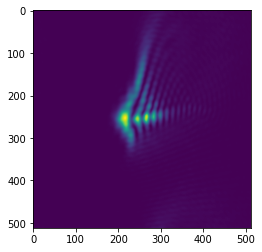

In [525]:
imshow(array)